In [1]:
import numpy as np
import copy
import time
import pandas as pd
from math import comb, log, log2, log10, e, exp, pow, sqrt, sin, cos, tan, pi, floor, ceil, tanh
from scipy.fft import fft, ifft
from statistics import NormalDist
import matplotlib.pyplot as plt
%matplotlib inline


# compute the log(tanh(l/2)) value of l
# for changing domain between L (record p(x=0)/p(x=1)) and D (record log(1-2p(x=1)))
def f(l):
    t=0-np.log(np.tanh(l/2))
    return t

# multiply W with each layer of X along the first axis
def mul(X,W):
    s=X.shape
    m=s[0]
    n=s[1]
    s=W.shape
    k=s[1]
    Y=np.zeros((m,n,k))
    for i in np.arange(0,m):
        Y[i,:,:]=X[i,:,:]@W
    return Y

# generate channel LLR densities for BIAWGN channel
def biawgn(sigma, N1, sample):
    lh=np.zeros(2*N1+1)
    stah=NormalDist(2/(sigma**2), 2/sigma)
    lh[0]=stah.cdf(sample[0])
    lh[2*N1]=1-stah.cdf(sample[2*N1-1])
    for i in np.arange(1,2*N1):
        lh[i]=stah.cdf(sample[i])-stah.cdf(sample[i-1])
    return lh

# generate channel LLR densities for BSC
def bsc(p, N1, sample):
    lh=np.zeros(2*N1+1)
    n1=sum(sample<log2((1-p)/p))
    n2=sum(sample<(-log2((1-p)/p)))
    lh[n1]=1-p
    lh[n2]=p
    print("capacity=",capacity(p,"bsc"))
    return lh

# output channel capacities for bsc or awgn channel
def capacity(p, mode="awgn"):
    if mode=="bsc":
        C=1+p*log2(p)+(1-p)*log2(1-p)
    else:
        C=log2(1+1/(p**2))/2
    return C

# L: arrays
# Apply fft along the last axis
# Zero padding the vector along the last axis (of length n) to length d*(n-1)+1
# (the result can be used for computing convolution of d vectors of length n)
def FFT(L, d):
    s=L.shape
    T=0
    if len(s)==3:
        m=s[0]
        k=s[1]
        n=s[2]
        T=np.zeros((m,k,d*(n-1)+1),dtype=complex)
        X=np.zeros((m,k,d*(n-1)+1))
        X[:,:,0:n]=copy.deepcopy(L)
        for i in np.arange(0,m):
            for t in np.arange(0,k):
                T[i,t,:]=fft(X[i,t,:])
    if len(s)==2:
        m=s[0]
        n=s[1]
        T=np.zeros((m,d*(n-1)+1),dtype=complex)
        X=np.zeros((m,d*(n-1)+1))
        X[:,0:n]=copy.deepcopy(L)
        for i in np.arange(0,m):
            T[i,:]=fft(X[i,:])
    if len(s)==1:
        n=len(L)
        T=np.zeros((d*(n-1)+1,),dtype=complex)
        X=np.zeros((d*(n-1)+1,))
        X[0:n]=copy.deepcopy(L)
        T=fft(X)
    return T


# L: arrays
# Apply ifft along the last axis
# Output vector length along the last axis identical to that of the input
# (needs further truncation based on the "d" parameter chosen in FFT applied to them)
def IFFT(L):
    s=L.shape
    T=0
    if len(s)==3:
        m=s[0]
        k=s[1]
        n=s[2]
        T=np.zeros((m,k,n))
        for i in np.arange(0,m):
            for t in np.arange(0,k):
                T[i,t,:]=np.real(ifft(L[i,t,:]))
    if len(s)==2:
        m=s[0]
        n=s[1]
        T=np.zeros((m,n))
        for i in np.arange(0,m):
            T[i,:]=np.real(ifft(L[i,:]))
    if len(s)==1:
        T=np.real(ifft(L))
    return T


In [2]:
# input LLRs on L domain (not uniformly sampled): range from Nc-N1<0 to Nc+N1>0, Nc<N1
# positive part: [(N1-Nc+1):(2*N1+1)]
# zero: N1-Nc
# negative part: [0:(N1-Nc)]
# Nc is the center
# output symmetric (even) part and antisymmetric (odd) part
# the convolution of Le and Lo on G domain is the Le and Lo for the out message distribution of CNs
def L2eo(L, N1, Nc):
    s=L.shape
    Le=0
    Lo=0
    if len(s)==3:
        Lp=L[:,:,(N1-Nc):(2*N1+1)]
        Ln=np.zeros((s[0],s[1],N1+Nc+1))
        Ln[:,:,1:(N1-Nc+1)]=L[:,:,np.flip(np.arange(0,N1-Nc))]
        Le=Lp+Ln
        Lo=Lp-Ln
        Lo[:,:,0]=np.zeros((s[0],s[1]))
    if len(s)==2:
        Lp=L[:,(N1-Nc):(2*N1+1)] # postive part of L domain messages N1, N1+1, ..., 2*N1
        Ln=np.zeros((s[0],N1+Nc+1))
        Ln[:,1:(N1-Nc+1)]=L[:,np.flip(np.arange(0,N1-Nc))] # negative part of L domain messages N1, N1-1, ..., 0
        Le=Lp+Ln # symmetric (even) part
        Lo=Lp-Ln # antisymmetric (odd) part
        Lo[:,0]=np.zeros(s[0])
    if len(s)==1:
        Lp=L[(N1-Nc):(2*N1+1)] # postive part of L domain messages N1, N1+1, ..., 2*N1
        Ln=np.zeros(N1+Nc+1)
        Ln[1:(N1-Nc+1)]=L[np.flip(np.arange(0,N1-Nc))] # negative part of L domain messages N1, N1-1, ..., 0
        Le=Lp+Ln # symmetric (even) part
        Lo=Lp-Ln# antisymmetric (odd) part      
        Lo[0]=0
    return [Le, Lo]


def eo2L(Le, Lo, N1, Nc):
    s=Le.shape
    L=0
    if len(s)==3:
        L=np.zeros((s[0],s[1],2*N1+1))
        L[:,:,0:(N1-Nc)]=((Le-Lo)/2)[:,:,np.flip(np.arange(1,N1-Nc+1))]
        L[:,:,(N1-Nc):(2*N1+1)]=(Le+Lo)/2
        L[:,:,N1-Nc]=Le[:,:,0]
    if len(s)==2:        
        L=np.zeros((s[0],2*N1+1))
        L[:,0:(N1-Nc)]=((Le-Lo)/2)[:,np.flip(np.arange(1,N1-Nc+1))] # negative part
        L[:,(N1-Nc):(2*N1+1)]=(Le+Lo)/2 # positive part
        L[:,N1-Nc]=Le[:,0]
    if len(s)==1:
        L=np.zeros(2*N1+1)
        L[0:(N1-Nc)]=((Le-Lo)/2)[np.flip(np.arange(1,N1-Nc+1))] # negative part
        L[(N1-Nc):(2*N1+1)]=(Le+Lo)/2 # positive part
        L[N1-Nc]=Le[0]
    return L

N1=6
Nc=2
L=np.tile(np.arange(0,2*N1+1),(2,3,1))
T=L2eo(L, N1, Nc)
print("Le=",T[0])
print("Lo=",T[1])
Lx=eo2L(T[0],T[1], N1, Nc)
print("L=",L)
print("Lx=",Lx)

Le= [[[ 4.  8.  8.  8.  8.  9. 10. 11. 12.]
  [ 4.  8.  8.  8.  8.  9. 10. 11. 12.]
  [ 4.  8.  8.  8.  8.  9. 10. 11. 12.]]

 [[ 4.  8.  8.  8.  8.  9. 10. 11. 12.]
  [ 4.  8.  8.  8.  8.  9. 10. 11. 12.]
  [ 4.  8.  8.  8.  8.  9. 10. 11. 12.]]]
Lo= [[[ 0.  2.  4.  6.  8.  9. 10. 11. 12.]
  [ 0.  2.  4.  6.  8.  9. 10. 11. 12.]
  [ 0.  2.  4.  6.  8.  9. 10. 11. 12.]]

 [[ 0.  2.  4.  6.  8.  9. 10. 11. 12.]
  [ 0.  2.  4.  6.  8.  9. 10. 11. 12.]
  [ 0.  2.  4.  6.  8.  9. 10. 11. 12.]]]
L= [[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]]

 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]]]
Lx= [[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]]

 [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
  [ 0.  1

In [3]:
# domain transform matrix for L2D and D2L
def s2t(s, t, isrightinfty):
    Ns=len(s)
    Nt=len(t)
    D=np.tile(np.reshape(t,(Nt,1)),(1,Ns))-np.tile(s,(Nt,1))
    ind=np.sum(D>=0,axis=1)-1 ## s[ind[i]]<=t[i]<s[ind[i]+1]
    if ind[0]<0:
        ind[0]=0
    if ind[Nt-1]>(Ns-2):
        ind[Nt-1]=Ns-2
    x=(t-s[ind])/(s[ind+1]-s[ind])
    T=0
    if isrightinfty:
        T=np.zeros((Ns,Nt))
    else:
        T=np.zeros((Ns-1,Nt-1))
    for n in np.arange(0,Nt-1):
        n1=ind[n]
        n2=ind[n+1]
        if n1==n2:
            T[n1,n]=x[n+1]-x[n]
        else:
            T[n1,n]=1-x[n]
            T[n2,n]=x[n+1]
            for i in np.arange(n1+1,n2):
                T[i,n]=1
    if isrightinfty:
        n=ind[Nt-1]
        if n==(Ns-1):
            T[Ns-1,Nt-1]=1
        else:
            T[n,Nt-1]=1-x[Nt-1]
            for i in np.arange(n+1,Ns):
                T[i,Nt-1]=1
            
    return np.fliplr(T)


# generate the transform matrices
# L2D1: (N1+Nc+1)*(N3+1)
# L2D2: (N1+Nc+1)*(N4+1)
# D2L1: (N3+1)*(N1+Nc-N2)
# D2L2: (N4+1)*(N2+1)
# lb<0<ub
def LD_sample(mode, lb, ub, alpha):
    xf=log(1+sqrt(2))
    N1=round((ub-lb)/(2*alpha)+0.5)
    Nc=round((ub+lb)/(2*alpha)+0.5)
    sample=alpha*(np.arange((Nc-N1),(Nc+N1))+0.5)
    beta=0
    if mode=="awgn":
        beta=(xf/(ub-xf))*alpha
    if mode=="bsc":
        beta=(xf/(ub-xf))*alpha
    N2=ceil((xf/alpha)-0.5)
    N3=ceil((xf/beta)-0.5)
    N4=floor((f(alpha/2)/alpha)+0.5)
    la=sample[(N1-Nc):(2*N1)] # alpha/2, 3*alpha/2, ... f(beta/2)=(2*(N1+Nc)-1)*alpha/2
    ga=la[0:(N4+1)] # alpha/2, 3*alpha/2, ..., (2*N4-1)*alpha/2
    gb=beta*(np.arange(0,N3+1)+0.5) # beta/2, 3*beta/2, ..., (2*N3+1)*beta/2
    # ((2*N1-1)*alpha/2, ..., xf-)
    s1=np.zeros(N1+Nc+1)
    s1[0]=0 
    s1[1:(N1+Nc+1)]=copy.deepcopy(la) # 0 alpha/2, 3*alpha/2, ... f(beta/2)=(N1+Nc-0.5)*alpha
    
    # left to xf
    tg1=f(np.flip(gb)) # xf-, ..., f(beta/2)=(N1-0.5)*alpha
    # right to xf
    tg2=np.zeros(N4+1)
    tg2[1:(N4+1)]=np.flip(f(ga[0:N4])) # (alpha/2)+, ..., f(alpha/2)<f(beta/2)
    
    sg1=np.zeros(N3+2)
    sg1[1:(N3+2)]=gb
    sg2=ga
    
    t1=np.zeros(N1+Nc-N2+1)
    t1[1:(N1+Nc-N2+1)]=f(np.flip(s1[(N2+1):(N1+Nc+1)]))
    t2=f(np.flip(s1[1:(N2+2)]))

    L2D1=(s2t(s1,tg1,True))[:,:]
    L2D2=(s2t(s1,tg2,True))[:,:]
    D2L1=(s2t(sg1,t1,False))[:,:]
    D2L2=(s2t(sg2,t2,True))[:,:]
    
    return [beta, sample, Nc, N1, N2, N3, N4, L2D1, L2D2, D2L1, D2L2]

s=LD_sample("bsc",-10,25,2e-2)
print(s[0],s[2],s[3],s[4],s[5],s[6])
t=np.sum(s[7]@s[9],axis=1)+np.sum(s[8]@s[10],axis=1)
print(sum(t))
print("L2D1:",s[7].shape)
print("L2D2:",s[8].shape)
print("D2L1:",s[9].shape)
print("D2L2:",s[10].shape)

0.0007308654911999421 376 876 44 1206 265
1254.0286371463737
L2D1: (1253, 1207)
L2D2: (1253, 266)
D2L1: (1207, 1208)
D2L2: (266, 45)


In [4]:
# FFT on D domain for BLOCK codes
# input LLRs on D domain (only positive part)
# T1: finer grained fft for the part left to the fixed point x0
# T2: coarser grained fft for the part right to the fixed point x0
# L: Le=Lp+Ln or Lo=Lp-Ln
# L2D1: (N1+1)*(N3+1)
# L2D2: (N1+1)*(N4+1)
# Note: apply D_FFT on Le and Lo seperatedly for CN density evolution 
def D_fft(L, L2D1, L2D2, d):
    T0=FFT(L@L2D1,d)
    T1=FFT(L@L2D2,d)
    return [T0, T1]

# IFFT on D domain for BLOCK codes
# ouput LLRs on D domain (only positive part)
# T=[T1, T2]
# L: Le=Lp+Ln or Lo=Lp-Ln
# D2L1: (N3+1)*(N1-N2)
# D2L2: (N4+1)*(N2+1)
# Note: apply D_IFFT on Te (FFT of Le) and To (FFT of Lo) seperatedly for CN density evolution 
def D_ifft(T, N1, N2, N3, N4, D2L1, D2L2, d):
    A1=np.real(IFFT(T[0]**d))
    A2=np.real(IFFT(T[1]**d))
    s=A1.shape
    L=0
    if len(s)==2:
        L1=A1[:,0:(N3+1)]@D2L1
        X=copy.deepcopy(A2[:,0:(N4+1)])
        X[:,N4]=np.sum(A2[:,N4:(d*N4+1)],axis=1)
        L2=X@D2L2
        L=np.zeros((s[0],N1+1))
        L[:,0:N2]=copy.deepcopy(L2[:,0:N2])
        L[:,(N2+1):(N1+1)]=copy.deepcopy(L1)
        L[:,N2]=np.sum(A2,axis=1)-np.sum(L,axis=1) #
    else:
        L1=A1[0:(N3+1)]@D2L1
        X=copy.deepcopy(A2[0:(N4+1)])
        X[N4]=sum(A2[N4:(d*N4+1)])
        L2=X@D2L2
        L=np.zeros(N1+1)
        L[0:N2]=copy.deepcopy(L2[0:N2])
        L[(N2+1):(N1+1)]=copy.deepcopy(L1)
        L[N2]=sum(A2)-sum(L) 
    return L

# VN convolution for BLOCK codes
# Input/output from L domain sample
# N: sample [-N, N]
# lc: cn->vn L density 
# lh: channel L density
# dv: allowed VN degrees
# lambd: degree distribution
# output: 
# lv: vn->cn L density
# v: L density e

def L_conv(lc, lh, dv, lambd, N1, Nc):
    dmax=max(dv)
    nd=len(dv)
    L=FFT(lc,dmax+1)
    H=FFT(lh,dmax+1)
    T=np.zeros((nd,2*N1+1))
    for i in np.arange(0,nd):
        d=dv[i]
        a=IFFT((L**(d-1))*H)
        N=d*(N1-Nc)
        T[i,:]=copy.deepcopy(a[(N-N1+Nc):(N+N1+Nc+1)])
        T[i,0]=sum(a[0:(N-N1+Nc+1)])
        T[i,2*N1]=sum(a[(N+N1+Nc):(2*d*N1+1)])
    lv=lambd@T
    lv[N1-Nc]=lv[N1-Nc]-(sum(lv)-1)
    a=IFFT((L**dmax)*H)
    N=(dmax+1)*(N1-Nc)
    v=copy.deepcopy(a[(N-N1+Nc):(N+N1+Nc+1)])
    v[0]=sum(a[0:(N-N1+Nc+1)])
    v[2*N1]=sum(a[(N+N1+Nc):(2*(dmax+1)*N1+1)])
    return [lv, v]

# CN convolution for BLOCK codes
def D_conv(lv, dc, rho, N1, Nc, N2, N3, N4, L2D1, L2D2, D2L1, D2L2):
    dmax=max(dc)
    nd=len(dc)
    L=L2eo(lv,N1,Nc)
    Le=L[0]
    Lo=L[1]
    Te=D_fft(Le, L2D1, L2D2, dmax-1)
    To=D_fft(Lo, L2D1, L2D2, dmax-1)
    Xe=np.zeros(N1+Nc+1)
    Xo=np.zeros(N1+Nc+1)
    for i in np.arange(0,nd):
        d=dc[i]-1
        Xe+=rho[i]*D_ifft(Te, N1+Nc, N2, N3, N4, D2L1, D2L2, d)
        Xo+=rho[i]*D_ifft(To, N1+Nc, N2, N3, N4, D2L1, D2L2, d)
    L=eo2L(Xe,Xo,N1,Nc)
    return L

# DE of block codes on AWGN channel
# sigma is the standard deviation
def de_block(mode, para, dc, dv, lambd, rho, R, sample, N1, Nc, N2, N3, N4, L2D1, L2D2, D2L1, D2L2):
    # edit to the L distribution of awgn(snr)
    lh=0
    if mode=="awgn":
        lh=biawgn(para,N1,sample)
    if mode=="bsc":
        lh=bsc(para,N1,sample)
    lv=copy.deepcopy(lh)
    #plt.plot(np.arange(-N1,N1),lv[0:(2*N1)],color='r')
    lc=0
    #print("lv=",sum(lv))
    T=np.zeros((R,2*N1+1))
    for r in np.arange(0,R):
        lc=copy.deepcopy(D_conv(lv, dc, rho, N1, Nc, N2, N3, N4, L2D1, L2D2, D2L1, D2L2))
        #print("lc=",sum(lc))
        s=L_conv(lc,lh,dv,lambd,N1,Nc)
        lv=copy.deepcopy(s[0])
        #print("lv=",sum(lv))
        T[r,:]=copy.deepcopy(s[1])
    return T


In [7]:
# obtain the BP-threshold (represented in SNR) of block codes on BIWAGN channel
# requirement: the accumulate probability of the negative part is less than eps
def bp_th(mode, eps, th, dc, dv, lambd, rho, R, lb, ub, alpha):
    xu=0
    if mode=="awgn":
        xu=10# edit to the awgn channel capacity
    if mode=="bsc":
        xu=0.5
    xl=0
    s=LD_sample(mode, lb, ub, alpha)
    beta=s[0]
    sample=s[1]
    Nc=s[2]
    N1=s[3]
    N2=s[4]
    N3=s[5]
    N4=s[6] 
    L2D1=s[7] 
    L2D2=s[8] 
    D2L1=s[9]
    D2L2=s[10]
    while (xu-xl)>eps:
        xt=(xu+xl)/2
        para=xt
        if mode=="awgn":
            para=10**(0-xt/20) # xt is the SNR, sigma is the standard deviation
        T=de_block(mode, para, dc, dv, lambd, rho, R, sample, N1, Nc, N2, N3, N4, L2D1, L2D2, D2L1, D2L2)
        y=abs(sum(T[R-1,0:(N1-Nc)]))
        if y>th:
            if mode=="awgn":
                xl=xt
            if mode=="bsc":
                xu=xt
        else:
            if mode=="awgn":
                xu=xt
            if mode=="bsc":
                xl=xt
    return xu

### the following codes calculate the threshold of codes under BIAWGN channel
dc=np.array([6])
rho=np.array([1.0])
dv=np.array([3])
lambd=np.array([1.0])
R=100
lb=-15
ub=50
alpha=3e-2
eps=1e-4
th=1e-4

mode="awgn"
snr_bp=bp_th(mode, eps, th, dc, dv, lambd, rho, R, lb, ub, alpha)
sigma=10**(0-snr_bp/20)
print("dc=",dc)
print("dv=",dv)
print("R=",R)# number of iterations
print("snr_bp=",snr_bp)# BP-threshold in SNR
print("sigma=",sigma)# BP threshold in standard deviation
print("sigma2=",sigma**2)# BP threshold in variance

### the following codes calculate the threshold of codes under BSC
dc=np.array([6])
rho=np.array([1.0])

dv=np.array([3])
lambd=np.array([1.0])
R=100
lb=-20
ub=40
alpha=3e-2
eps=1e-4
th=1e-4

mode="bsc"
p_bp=bp_th(mode, eps, th, dc, dv, lambd, rho, R, lb, ub, alpha)
sigma=10**(0-snr_bp/20)
print("dc=",dc)
print("dv=",dv)
print("R=",R)# number of iterations
print("p_bp=",p_bp)# BP-threshold in BSC

dc= [6]
dv= [3]
R= 100
snr_bp= 1.1168670654296875
sigma= 0.8793396307782863
sigma2= 0.7732381862572928
capacity= 0.18872187554086717
capacity= 0.4564355568004036
capacity= 0.6627099333829861
capacity= 0.5511355112769707
capacity= 0.6044621935435227
capacity= 0.5772376562208483
capacity= 0.5907037043794098
capacity= 0.597545591322192
capacity= 0.6009944483889362
capacity= 0.5992676721258672
capacity= 0.5984060464337972
capacity= 0.5979756727596028
capacity= 0.5977605955367515
dc= [6]
dv= [3]
R= 100
p_bp= 0.080078125


sigma= 0.8759917176331172
beta= 0.0006759237231758345
334 1000 29 1304 163
Finish!


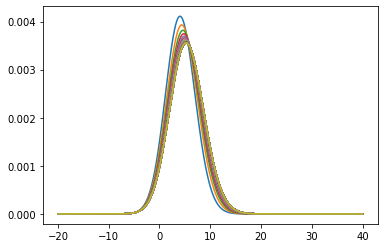

In [14]:
### the following codes plots the evolution of distribution of messages in different iterations

dc=np.array([6])
dv=np.array([2,4])
lambd=np.array([0.5,0.5])
rho=np.array([1.0])
R=100 # number of iterations
lb=-20 # lower bound of the message value
ub=40 # upper bound of the message value
alpha=0.03
L=100

mode="awgn" ## for BIAWGN channel, use this and the next line and comment out line 16
SNR=1.15
#mode="bsc" 
#p=0.080
para=0

if mode=="awgn":
    para=10**(0-SNR/20)
    print('sigma=',para)
    
if mode=="bsc":
    para=p


sampleresult=LD_sample(mode,lb,ub,alpha) # output=[beta, sample, Nc, N1, N2, N3, N4, L2D1, L2D2, D2L1, D2L2]
beta=sampleresult[0]
print("beta=",beta)
sample=sampleresult[1]
Nc=sampleresult[2]
N1=sampleresult[3]
N2=sampleresult[4] 
N3=sampleresult[5] 
N4=sampleresult[6] 
L2D1=sampleresult[7]
L2D2=sampleresult[8]
D2L1=sampleresult[9]
D2L2=sampleresult[10]
print(Nc,N1,N2,N3,N4)

T=de_block(mode, para, dc, dv, lambd, rho, R, sample, N1, Nc, N2, N3, N4, L2D1, L2D2, D2L1, D2L2)

print("Finish!")

for r in np.arange(1,R):
    plt.plot(sample,T[r,0:(2*N1)])
    